In [366]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
from scipy.signal import savgol_filter

### Double Pendulum Model and Data Generation

Initialize parameters

In [367]:
params = {}
params['m1'] = 0.2704 # mass 1
params['m2'] = 0.2056 # mass 2
params['L1'] = 0.2667 # length 1
params['L2'] = 0.2667 # length 2
params['a1'] = 0.191 # com 1
params['a2'] = 0.1621 # com 2
params['I1'] = 0.003 # inertia 1
params['I2'] = 0.0011 # inertia 2
params['g'] = 9.81 # gravity
print(params)

{'m1': 0.2704, 'm2': 0.2056, 'L1': 0.2667, 'L2': 0.2667, 'a1': 0.191, 'a2': 0.1621, 'I1': 0.003, 'I2': 0.0011, 'g': 9.81}


Pendulum dynamics and solver

In [368]:
def ssDoublePendulum(x:np.ndarray, params:dict):
    ''' 
    this function evaluates the differential equation of the double pendulum model in the state-space form
    input:
    x:- state of the double pendulum; [ph1, ph2, dph1, dph2], 
        ph1, ph2: rotational angles of the two links,
        dph1, dph2: respective time dertivatives or velocities
    params:- dictionary consisting of model parameters; m1, m2, L1, L2, a1, a2, I1, I2, g
        m1, m2: mass of the links; 
        L1, L2: length of the links;
        a1, a2: position of the coms of the two links
        I1, I2: link inertias
        g: gravitational acceleration
    output:
    dx:- time derivative of the state x
    '''
    # state variables
    x1 = x[0] 
    x2 = x[1] 
    x3 = x[2] 
    x4 = x[3]

    # parameters
    m1 = params['m1']
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    a1 = params['a1']
    a2 = params['a2']
    I1 = params['I1']
    I2 = params['I2']
    g = params['g']
    k1=0
    k2=0

    M = np.array([
        [I1 + L1**2*m2 + a1**2*m1, L1*a2*m2*np.cos(x1-x2)],
        [L1*a2*m2*np.cos(x1-x2), I2 + a2**2*m2]
        ])
    
    # M = np.array([
    #     [1, 0.323*np.cos(x1-x2)],
    #     [1.358*np.cos(x1-x2), 1]
    # ])

    # vec = -np.dot(np.linalg.inv(M), np.array([
    #     (k1+k2)*x3 - k2*x4 + L1*a2*m2*np.sin(x1-x2)*x4**2 - L1*g*m2*np.sin(x1) - a1*g*m1*np.sin(x1),
    #     -k2*x3 + k2*x4 - L1*a2*m2*np.sin(x1-x2)*x3**2 - a2*g*m2*np.sin(x2)
    # ]))
    
    # vec = -np.dot(np.linalg.inv(M), 
    #               np.array([
    #                   0.03235*x3+0.323*x4**2*np.sin(x1-x2)-0.006006*x4-37.97*np.sin(x1),
    #                   -0.02525*x3+0.02525*x4-49.94*np.sin(x2)-1.358*x3**2*np.sin(x1-x2)
    #               ])
    #               )
    
    vec = np.array([
        (-0.2808*np.sin(2*x1-2*x2)*x3**2 - 0.4136*np.sin(x1-x2)*x4**2 + 10.3278*np.sin(x1-2*x2) + 38.2984*np.sin(x1))/(1-0.2808*np.cos(2*x1-2*x2)),
        (1.7390*np.sin(x1-x2)*x3**2 + 0.2808*np.sin(2*x1-2*x2)*x4**2 - 33.02*np.sin(2*x1-x2) + 30.9472*np.sin(x2))/(1-0.2808*np.cos(2*x1-2*x2))
    ])

    dx = np.array([x3, x4, vec[0], vec[1]])

    return dx

def rk4(xCurrent:np.ndarray, dt:float, params:dict):
    ''' 
    this function updates the current state by numerically integrating the continuous state-space dynamics of the pendulum
    input:
    xCurrent:- current state of the double pendulum; [ph1, ph2, dph1, dph2], 
        ph1, ph2: rotational angles of the two links,
        dph1, dph2: respective time dertivatives or velocities

    output:
    xNext:- next state of the double pendulum; [ph1, ph2, dph1, dph2],
        ph1, ph2: rotational angles of the two links,
        dph1, dph2: respective time dertivatives or velocities
    '''
    assert(xCurrent.shape == (4,))
    
    k1 = ssDoublePendulum(xCurrent, params)
    assert(k1.shape == (4,))

    k2 = ssDoublePendulum(xCurrent+dt*k1/2, params)
    assert(k2.shape == (4,))

    k3 = ssDoublePendulum(xCurrent+dt*k2/2, params)
    assert(k3.shape == (4,))

    k4 = ssDoublePendulum(xCurrent+dt*k3, params)
    assert(k4.shape == (4,))
    
    xNext = xCurrent + dt/6*(k1 + 2*k2 + 2*k3 + k4)
    assert(xNext.shape == (4,))

    return xNext

def totalEnergy(x:np.ndarray, params:dict):
    '''
    this function computes the total energy of the double pendulum system, given the state
    inputs:
    x:- current state of the double pendulum; [ph1, ph2, dph1, dph2], 
        ph1, ph2: rotational angles of the two links,
        dph1, dph2: respective time dertivatives or velocities
    
    output:
    E: kinetic energy + potential energy
    '''

    # state variables
    x1 = x[0] # phi_1 
    x2 = x[1] # phi_2
    x3 = x[2] # phi_dot_1
    x4 = x[3] # phi_dot_2

    # parameters
    m1 = params['m1'] 
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    a1 = params['a1']
    a2 = params['a2']
    I1 = params['I1']
    I2 = params['I2']
    g = params['g']
    k1 = 0
    k2 = 0

    KE = 0.5*(
        m2*((L1*np.cos(x1)*x3+a2*np.cos(x2)*x4)**2 + (L1*np.sin(x1)*x3 + a2*np.sin(x2)*x4)**2)
        ) + 0.5*(
        m1*(a1*x3)**2*(np.cos(x1**2) + np.sin(x1**2))
        ) + 0.5*(I1*x3**2 + I2*x4**2)
    PE = m2*g*(a2*np.cos(x2) + L1*np.cos(x1)) + a1*g*m1*np.cos(x1)
    E = KE + PE

    return np.array([KE, PE, E])


def moving_average_filter(data, window_size):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')


def myNorm(M, normType:str):
    
    if normType == 'infinity_norm':
        norm = np.max(np.abs(M))
    elif normType == '2_norm':
        norm = np.linalg.norm(M)

    return norm


Solve the double pendulum model and generate data

In [430]:
# initialize simulation parameters
tStart = 0.0
tEnd_train = 10.0
tEnd_test = 3.0
tStep = 0.001
N_train = int((tEnd_train-tStart)/tStep)
N_test = int((tEnd_test-tStart)/tStep)
time = np.linspace(tStart, tEnd_train, N_train)
time1 = np.linspace(tStart, tEnd_test, N_test)

X = np.zeros(shape=(N_train,4)) # state data
Xm = np.zeros(shape=(N_train,4)) # measured state data
Xdot = np.zeros(shape=(N_train,4)) # state velocity data
XdotNum = np.zeros(shape=(N_train,4)) # numerical state velocity data
# trainEnergy = np.zeros(shape=(N_train,3)) # energy vector data
# trainEnergy[0,:] = totalEnergy(X[0,:], params)

X1 = np.zeros(shape=(N_test,4)) # state data
Xm1 = np.zeros(shape=(N_test,4)) # measured state data
X1dot = np.zeros(shape=(N_test,4)) # state velocity data
X1dotNum = np.zeros(shape=(N_test,4)) # numerical state velocity data
# testEnergy = np.zeros(shape=(N_test,3)) # energy vector data
# testEnergy[0,:] = totalEnergy(X1[0,:], params)

# state measurement noise parameters
mean = np.array([0,0,0,0])
stddev = 1e-4
cov = stddev**2*np.diag([1,1,1,1])

# obtain training data from dynamics
X[0,:] = np.array([np.pi+1.2, np.pi-0.6, 0, 0]) # initial state
# X[0,:] = x
Xm[0,:] = X[0,:] + np.random.multivariate_normal(mean, cov)
for i in range(N_train-1):
    X[i+1,:] = rk4(X[i,:], tStep, params) # true state
    # X[i+1,:] = x
    Xdot[i+1,:] = ssDoublePendulum(X[i+1,:], params) # true velocity
    Xm[i+1,:] = X[i+1,:] + np.random.multivariate_normal(mean, cov) # measured state
    XdotNum[i+1,:] = (Xm[i+1,:]-Xm[i,:])/tStep # numerically computed velocity from measured state
    # XdotNum[i+1,:] = Xdot[i+1,:] + np.random.multivariate_normal(mean, 10*cov) 
    # trainEnergy[i+1] = totalEnergy(trainX[i+1,:], params)
# X[0,:] = np.array([0, 0, 0, 0])

# test data
X1[0,:] = np.array([np.pi-1, np.pi-0.4, 0.3, 0.4]) # initial state
# X1[0,:] = y
Xm1[0,:] = X1[0,:] + np.random.multivariate_normal(mean, cov)
for i in range(N_test-1):
    X1[i+1,:] = rk4(X1[i,:], tStep, params) # true state
    # X1[i+1,:] = y
    X1dot[i+1,:] = ssDoublePendulum(X1[i+1,:], params) # true velocity 
    Xm1[i+1,:] = X1[i+1,:] + np.random.multivariate_normal(mean, cov) # measured state
    X1dotNum[i+1,:] = (Xm1[i+1,:]-Xm1[i,:])/tStep # numerically computed velocity from the measured state
    # X1dotNum[i+1,:] = X1dot[i+1,:] + np.random.multivariate_normal(mean, 10*cov)
    # testEnergy[i+1] = totalEnergy(testX[i+1,:], params)
# X1[0,:] = np.array([0, 0, 0, 0])

# cut and smoothen the data
t = 100
trainXExact = X[t:,:]
trainXdotExact = Xdot[t:,:]
trainX = Xm[t:,:]
trainXdot = XdotNum[t:,:]

testXExact = X1[t:,:]
testXdotExact = X1dot[t:,:]
testX = Xm1[t:,:]
testXdot = X1dotNum[t:,:]


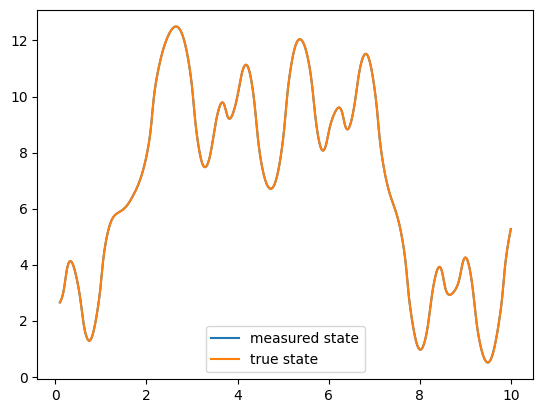

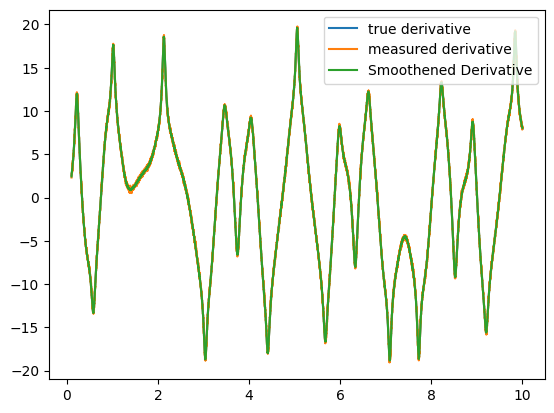

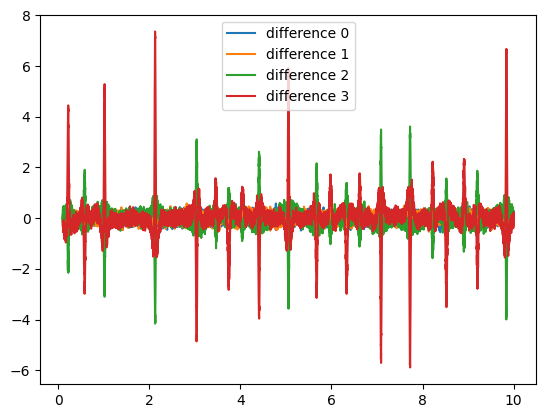

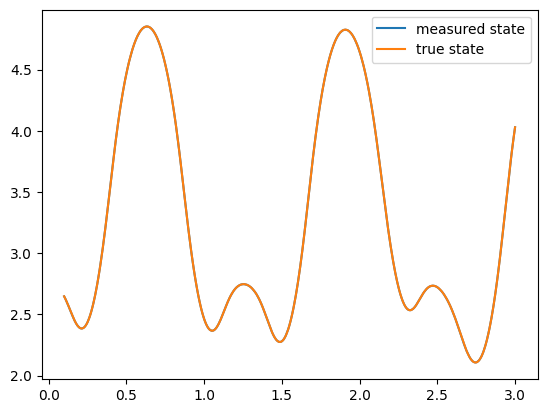

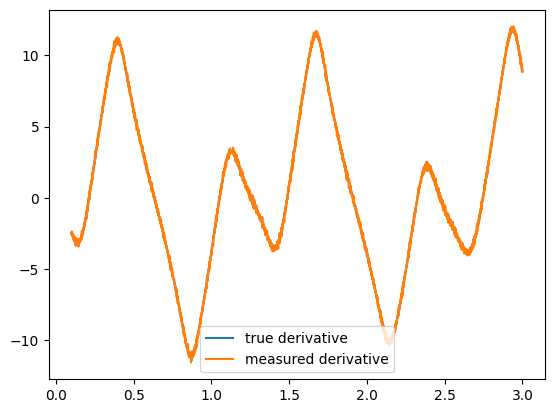

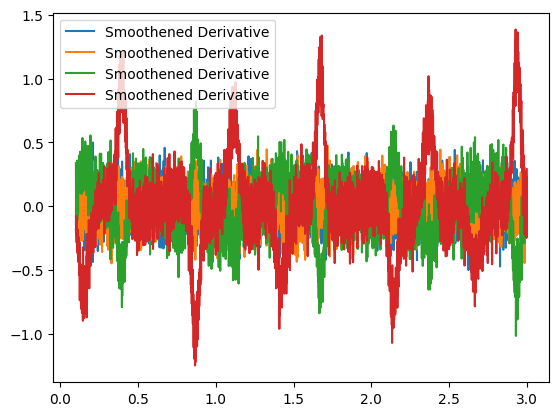

In [431]:
trainXdotS = np.zeros((N_train-t,4))
testXdotS = np.zeros((N_test-t,4))
wl = 10
po = 2
for i in range(4):
    trainXdotS[:,i] = savgol_filter(trainXdot[:,i], window_length=wl, polyorder=po)
    testXdotS[:,i] = savgol_filter(testXdot[:,i], window_length=wl, polyorder=po)

# make plots parameters
make_plots = True
col = 1

if make_plots == True:
    plt.figure(1)
    plt.plot(time[t:], trainX[:,col], label='measured state')
    plt.plot(time[t:], trainXExact[:,col], label='true state')
    plt.legend()
    # plt.show()

    plt.figure(2)
    plt.plot(time[t:], trainXdotExact[:, col], label='true derivative')
    plt.plot(time[t:], trainXdot[:,col], label = 'measured derivative')
    plt.plot(time[t:], trainXdotS[:,col], label = 'Smoothened Derivative')
    plt.legend()
    plt.show()
    
    plt.figure(3)
    plt.plot(time[t:], trainXdot[:,0]-trainXdotExact[:, 0], label='difference 0')
    plt.plot(time[t:], trainXdot[:,1]-trainXdotExact[:, 1], label='difference 1')
    plt.plot(time[t:], trainXdot[:,2]-trainXdotExact[:, 2], label='difference 2')
    plt.plot(time[t:], trainXdot[:,3]-trainXdotExact[:, 3], label='difference 3')
    plt.legend()
    plt.show()

    plt.figure(4)
    plt.plot(time1[t:], testX[:,col], label='measured state')
    plt.plot(time1[t:], testXExact[:,col], label='true state')
    plt.legend()
    plt.show()

    plt.figure(5)
    plt.plot(time1[t:], testXdotExact[:, col], label='true derivative')
    plt.plot(time1[t:], testXdot[:,col], label = 'measured derivative')
    plt.legend()
    plt.show()

    plt.figure(6)
    plt.plot(time1[t:], testXdot[:,0]-testXdotExact[:,0], label = 'Smoothened Derivative')
    plt.plot(time1[t:], testXdot[:,1]-testXdotExact[:,1], label = 'Smoothened Derivative')
    plt.plot(time1[t:], testXdot[:,2]-testXdotExact[:,2], label = 'Smoothened Derivative')
    plt.plot(time1[t:], testXdot[:,3]-testXdotExact[:,3], label = 'Smoothened Derivative')
    plt.legend()
    plt.show()


### Library Generation

In [432]:
def libraryDoublePendulum(x:np.ndarray, xdot:np.ndarray):
    ''' 
    this function computes the library of functions given the trajectory data
    inputs:
    x - state, phi_1 = x[0], phi_2 = x[1], phi_dot_1 = x[2], phi_dot_2 = x[3]
    xdot - state, phi_dot_1 = xdot[0], phi_dot_2 = xdot[1], phi_ddot_1 = x[2], phi_ddot_2 = x[3]
    output:
    Th - library of functions (implicit function of the state trajectory) 
    '''
    # validate state and velocity vector shapes for the double pendulum model
    assert(x.shape == (4,))
    assert(xdot.shape == (4,))

    funcs = [
        x[0],
        x[1],
        xdot[0],
        xdot[1],
        xdot[2],
        xdot[3],
        xdot[2]*xdot[3],
        np.sin(x[0]),
        np.sin(x[1]),
        np.cos(x[0]),
        np.cos(x[1]),
        np.sin(x[0]-2*x[1]),
        np.cos(x[0]-2*x[1]),
        np.sin(2*x[0]-x[1]),
        np.cos(2*x[0]-x[1]),
        xdot[0]*np.sin(x[0]),
        xdot[0]*np.sin(x[1]),
        xdot[0]*np.cos(x[0]),
        xdot[0]*np.cos(x[1]),
        xdot[1]*np.sin(x[0]),
        xdot[1]*np.sin(x[1]),
        xdot[1]*np.cos(x[0]),
        xdot[1]*np.cos(x[1]),
        xdot[2]*np.sin(x[0]),
        xdot[2]*np.sin(x[1]),
        xdot[2]*np.cos(x[0]),
        xdot[2]*np.cos(x[1]),
        xdot[3]*np.sin(x[0]),
        xdot[3]*np.sin(x[1]),
        xdot[3]*np.cos(x[0]),
        xdot[3]*np.cos(x[1]),
        xdot[0]**2*np.sin(x[0]-x[1]),
        xdot[0]**2*np.cos(x[0]-x[1]),
        xdot[1]**2*np.sin(x[0]-x[1]),
        xdot[1]**2*np.cos(x[0]-x[1]),
        xdot[0]**2*np.sin(2*(x[0]-x[1])),
        xdot[0]**2*np.cos(2*(x[0]-x[1])),
        xdot[1]**2*np.sin(2*(x[0]-x[1])),
        xdot[1]**2*np.cos(2*(x[0]-x[1])),
        xdot[2]*np.cos(2*(x[0]-x[1])),
        xdot[2]*np.sin(2*(x[0]-x[1])),
        xdot[3]*np.cos(2*(x[0]-x[1])),
        xdot[3]*np.sin(2*(x[0]-x[1])),
        x[0]**2,
        x[1]**2,
        xdot[0]**2,
        xdot[1]**2,
        xdot[2]**2,
        xdot[3]**2,
        x[0]*x[1],
        x[0]*xdot[0],
        x[0]*xdot[1],
        x[0]*xdot[2],
        x[0]*xdot[3],
        x[1]*xdot[0],
        x[1]*xdot[1],
        x[1]*xdot[2],
        x[1]*xdot[3],
    ]

    # funcs = [
    #     xdot[2],
    #     xdot[3],
    #     np.sin(x[0]),
    #     np.sin(x[1]),
    #     np.cos(x[0]),
    #     np.cos(x[1]),
    #     np.sin(x[0]-2*x[1]),
    #     np.cos(x[0]-2*x[1]),
    #     np.sin(2*x[0]-x[1]),
    #     np.cos(2*x[0]-x[1]),
    #     xdot[0]**2*np.sin(x[0]-x[1]),
    #     xdot[0]**2*np.cos(x[0]-x[1]),
    #     xdot[1]**2*np.sin(x[0]-x[1]),
    #     xdot[1]**2*np.cos(x[0]-x[1]),
    #     xdot[0]**2*np.sin(2*(x[0]-x[1])),
    #     xdot[0]**2*np.cos(2*(x[0]-x[1])),
    #     xdot[1]**2*np.sin(2*(x[0]-x[1])),
    #     xdot[1]**2*np.cos(2*(x[0]-x[1])),
    #     xdot[2]*np.cos(2*(x[0]-x[1])),
    #     xdot[2]*np.sin(2*(x[0]-x[1])),
    #     xdot[3]*np.cos(2*(x[0]-x[1])),
    #     xdot[3]*np.sin(2*(x[0]-x[1]))
    # ] # this library works without noise


    return np.array(funcs)

def computeLibAlongTrajectory(X:np.ndarray, Xdot:np.ndarray):
    ''' 
    this function computes the library along the state trajectory
    inputs:
    X - state trajectory
    Xdot - state velocity trajectory
    output:
    TH - library of function along the trajectory
    '''
    # validate state and velocity trajectory shapes for the double pendulum model
    assert(X.shape[1] == 4)
    assert(Xdot.shape[1] == 4)
    temp = libraryDoublePendulum(X[0,:], Xdot[0,:])

    TH = np.zeros(shape = (X.shape[0],len(temp)))

    for t in range(len(X[:,0])):
        TH[t] = libraryDoublePendulum(X[t,:], Xdot[t,:])

    return TH

### Optimization using Sequentially Thresholded Least Squares

In [433]:
def trainModel(trainXData:np.ndarray, trainXDotData:np.ndarray, normType:str, lmdType:str, lmdMag:float, maxIters:int, tol:float, allowPrint=False):
    '''
    This function trains the implicit model based on the state and the state derivative data using Sequentially Thresholded Least Squares Optimization.
    The optimization results into a coefficient matrix to approximate the implicit system model as a linear combination of functions defined in the function library.
    Inputs: 
    trainXData - state measurement data for training. 2D numpy array with time along the axis 0 and states along the axis 1
    trainXDotData - state time-derivative measurement data for training. 2D numpy array with time along the axis 0 and states along the axis 1
    XiInit - Initial coefficients 2D numpy array for the function library. This is the optimization variable
    normType - A string to indicate the type of norm for computing matrix/vector norms. The options are 1-norm and 2-norm
    lmdType - A string to indicate the type of thresholding hyperparameter for sparsification of Xi while performing STLSQ iterations
    lmdMag - Magnitude of the thresholding hyperparameter
    maxIters - Maximum number of iterations for STLSQ optimization
    tol - Tolerance to achieve the convergence
    allowPrint - Boolean to indicate whether to print the iteration updates
    '''

    TH = computeLibAlongTrajectory(trainXData, trainXDotData) # library computed along the training data
    Xi = 100*np.ones((TH.shape[1],TH.shape[1])) - 100*np.eye(TH.shape[1]) # initialize the coefficient matrix with zero diagonal entries
    assert(np.all(np.diag(Xi)==0.0)) # check if the diagonal entries of Xi are zeroed or not
    
    np.random.seed(0) # fix the realizations of any random variable outcomes
    if lmdType == 'gaussian':
        lmd = lmdMag*np.abs(np.random.multivariate_normal(
            np.zeros(TH.shape[1]),
            np.eye(TH.shape[1])
        ))
    elif lmdType == 'const':
        lmd = lmdMag*np.ones(TH.shape[1]+1)

    if allowPrint == True:
        print('TH shape = ', TH.shape, 'Xi shape = ', Xi.shape)
        print('lambda parameter = ', lmd)

    print('\nSTQSL Iterations')
    for iter in range(maxIters):
        Xi_prev = Xi.copy() # previous iteration Xi value
        assert(np.all(np.diag(Xi) == 0.0)) # check if diagonal entries of Xi are zero
        for col in range(Xi.shape[1]): # update nonzero entries of Xi by performing linear regression on only them
            smallinds = np.abs(Xi[:,col]) < lmd[col]
            biginds = ~smallinds
            A = TH[:,biginds]
            Anorm = np.linalg.norm(A)
            b = TH[:,col]
            bnorm = np.linalg.norm(b)
            Ah = np.dot(A.T,A)
            Ahnorm = np.linalg.norm(Ah)
            bh = np.dot(A.T,b)
            bhnorm = np.linalg.norm(bh)
            Xi[biginds, col] = np.dot(np.linalg.inv(Ah), bh)
            Xinorm = np.linalg.norm(Xi[:,col])
            Xi[smallinds,col] = 0.0

        # print('Xi column', Xi[:,4])
        norm = myNorm(Xi - Xi_prev, normType)/myNorm(Xi, normType) # compute difference norm

        if allowPrint == True:
            print(f'iter = {iter}, norm = {norm}, normXi = {myNorm(Xi, normType)}, normXi_prev = {myNorm(Xi_prev, normType)}')
        if norm < tol: # stopping condition
            print(f'tolerance achieved, norm = {norm} < {tol}, iterations = {iter}')
            break
        elif iter == maxIters-1:
            print(f'maximum iterations achieved, norm = {norm}')

    return Xi

def validateModel(testXData:np.ndarray, testXDotData:np.ndarray, Xi:np.ndarray, allowPrint=False):
    ''' 
    The function to validate the trained model using STLSQ iterations based on the test data
    Inputs:
    testXData - state measurement data for testing. 2D numpy array with time along the axis 0 and states along the axis 1
    testXDotData - state time-derivative measurement data for testing. 2D numpy array with time along the axis 0 and states along the axis 1
    Xi - Optimal coefficient matrix for function library of the implicit dynamic model
    allowPrint - Boolean to whether print model validation information or not
    '''

    testTH = computeLibAlongTrajectory(testXData, testXDotData) # library computed along the testing data
    relativeModelFit = np.ones(testTH.shape[1])

    for col in range(testTH.shape[1]):
        assert(Xi[col,col] == 0.0)
        relativeModelFit[col] = myNorm(
            testTH[:,col]-np.dot(testTH,Xi[:, col]), '2_norm'
            )/myNorm(testTH[:,col], '2_norm')

    sorted_indices = np.argsort(relativeModelFit)
    sortedRelativeModelFit = relativeModelFit[sorted_indices]

    if allowPrint == True:
        print('\nmodel fit relative error = \n' , sortedRelativeModelFit)
        print('corresponding indices = \n', sorted_indices)
        for i in range(len(sortedRelativeModelFit)):
            print('Coefficients corresponding to the index =', sorted_indices[i], 'fit error = ', sortedRelativeModelFit[i], '\n', Xi[:,sorted_indices[i]])
        # print('Coefficients corresponding to the second minimum fit error = \n' , Xi[:,sorted_indices[1]])
        # print('Coefficients corresponding to the third minimum fit error = \n' , Xi[:,sorted_indices[2]])
        # print('Coefficients corresponding to the fourth minimum fit error = \n' , Xi[:,sorted_indices[3]])
        # print('Coefficients corresponding to the fifth minimum fit error = \n' , Xi[:,sorted_indices[4]])
        # print('Coefficients corresponding to the sixth minimum fit error = \n' , Xi[:,sorted_indices[5]])
        # print('Coefficients corresponding to the seventh minimum fit error = \n' , Xi[:,sorted_indices[6]])
        # print('Coefficients corresponding to the eigth minimum fit error = \n' , Xi[:,sorted_indices[7]])

    pass

In [455]:
isDataNoisy = True
if isDataNoisy == True:
    trainXData = trainX
    trainXDotData = trainXdotS
    testXData = testX
    testXDotData = testXdotS
else:
    trainXData = trainXExact
    trainXDotData = trainXdotExact
    testXData = testXExact
    testXDotData = testXdotExact

# model training
print(np.linalg.norm(trainXdotS-trainXdotExact))
Xi = trainModel(trainXData, trainXDotData, normType='infinity_norm', lmdType='const', lmdMag=0.1, maxIters=20, tol=1e-10, allowPrint=True)
# model validation
validateModel(testXExact, testXDotData, Xi, allowPrint=True)

5.4942469711455955
TH shape =  (9900, 58) Xi shape =  (58, 58)
lambda parameter =  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1]

STQSL Iterations
iter = 0, norm = 1.0126316250585738, normXi = 7916.637767214608, normXi_prev = 100.0
iter = 1, norm = 0.05584761521473256, normXi = 7916.637767214608, normXi_prev = 7916.637767214608
iter = 2, norm = 0.004772866497459716, normXi = 7916.637767214608, normXi_prev = 7916.637767214608
iter = 3, norm = 0.0016039283399285377, normXi = 7916.637767214608, normXi_prev = 7916.637767214608
iter = 4, norm = 0.0013319069863248166, normXi = 7916.637767214608, normXi_prev = 7916.637767214608
iter = 5, norm = 2.1640392061543125e-05, normXi = 7916.637767214608, normXi_prev = 7916.637767214608
iter = 6, norm = 0.0009250990966427516, normXi = 7916.637767214608, normXi_